In [3]:
import numpy as np

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14630822120710919653
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3447128064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16254351882020772813
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
mode = 0

data_directory = "../DATASET/mode_" + str(mode) + "/downsampling/"

X_train = np.load(data_directory + "X_train.npy")
y_train = np.load(data_directory + "y_train.npy")

X_val = np.load(data_directory + "X_val.npy")
y_val = np.load(data_directory + "y_val.npy")

X_test = np.load(data_directory + "X_test.npy")
y_test = np.load(data_directory + "y_test.npy")

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2512, 250, 2)
(640, 250, 2)
(1022, 250, 2)


In [6]:
X_train_flat = X_train.reshape(-1, 500)
X_val_flat = X_val.reshape(-1, 500)
X_test_flat = X_test.reshape(-1, 500)

In [7]:
X_train_flat.shape

(2512, 500)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

max_features = 1024

model = Sequential()
model.add(Embedding(max_features, output_dim=256))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [17]:
history = model.fit(X_train_flat, y_train, batch_size=64, epochs=20, validation_data=(X_val_flat, y_val), shuffle=True)

Train on 2512 samples, validate on 640 samples
Epoch 1/20
2512/2512 [==============================] - 19s 8ms/step - loss: 0.4685 - acc: 0.8113 - val_loss: 0.4964 - val_acc: 0.8172
Epoch 2/20
2512/2512 [==============================] - 19s 7ms/step - loss: 0.4278 - acc: 0.8276 - val_loss: 0.4504 - val_acc: 0.8203
Epoch 3/20
2512/2512 [==============================] - 19s 7ms/step - loss: 0.4211 - acc: 0.8272 - val_loss: 0.4553 - val_acc: 0.8234
Epoch 4/20
2512/2512 [==============================] - 19s 7ms/step - loss: 0.4231 - acc: 0.8336 - val_loss: 0.4485 - val_acc: 0.8281
Epoch 5/20
2512/2512 [==============================] - 19s 7ms/step - loss: 0.4180 - acc: 0.8420 - val_loss: 0.4573 - val_acc: 0.8094
Epoch 6/20
2512/2512 [==============================] - 19s 7ms/step - loss: 0.4226 - acc: 0.8436 - val_loss: 0.4581 - val_acc: 0.8234
Epoch 7/20
2512/2512 [==============================] - 19s 7ms/step - loss: 0.4223 - acc: 0.8388 - val_loss: 0.4656 - val_acc: 0.8234
Epoch 8/

In [18]:
score = model.evaluate(X_val_flat, y_val, verbose=1, batch_size=64)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

640/640 [==============================] - 1s 1ms/step
Validation loss: 0.47499447762966157
Validation accuracy: 0.8203125


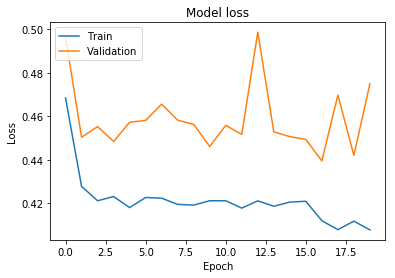

In [19]:
import matplotlib.pyplot as plt 

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [43]:
from sklearn.metrics import recall_score, precision_score, fbeta_score

def best_threshold(X_val, y_val):
    predictions = model.predict(X_val)
    
    best_f2 = 0
    for thresh in np.linspace(0.01, 0.99, 100):
        y_val_predict = (predictions > thresh).astype(np.uint8)
        
        f2 = fbeta_score(y_val, y_val_predict, beta=2)

        if f2 > best_f2:
            best_f2 = f2
            best_thresh = thresh
    return best_thresh

threshold = best_threshold(X_val_flat, y_val)
y_val_predict = (model.predict(X_val_flat) > threshold).astype(np.uint8)

print("Validation: ")
print("Threshold: ", threshold)
print("Precision: \t", precision_score(y_val, y_val_predict))
print("Recall: \t", recall_score(y_val, y_val_predict))
print("F2: \t\t", fbeta_score(y_val, y_val_predict, beta=2))

/home/francesco/anaconda3/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Validation: 
Threshold:  0.2871717171717172
Precision: 	 0.8172920065252854
Recall: 	 0.9920792079207921
F2: 		 0.9513862514242312


In [44]:
model.save("Models/mode_" + str(mode) + "/LSTM.h5")

In [45]:
from keras.utils import plot_model
plot_model(model, to_file='LSTMmode0.png') 

In [47]:
# TEST
y_test_predict = (model.predict(X_test_flat) > threshold).astype(np.uint8) 
print("TEST: ")
print("Threshold: ", threshold)
print("Precision: \t", precision_score(y_test, y_test_predict))
print("Recall: \t", recall_score(y_test, y_test_predict))
print("F2: \t\t", fbeta_score(y_test, y_test_predict, beta=2))

TEST: 
Threshold:  0.2871717171717172
Precision: 	 0.8252032520325203
Recall: 	 0.9914529914529915
F2: 		 0.9530516431924883
